In [1]:
import copy
import gym
import numpy as np
import scipy.integrate as si
import matplotlib.pyplot as plt
import matplotlib.ticker as tck
from stable_baselines3 import PPO, DDPG
from stable_baselines3.common.env_checker import check_env
from stable_baselines3.common.evaluation import evaluate_policy

In [2]:
class Swing(gym.Env):
    def __init__(self, target=np.pi, l_min=1, omega_0=-0.01):
        super(Swing, self).__init__()
        self.observation_space = gym.spaces.Box(
            low=np.array([0, -10, 0]),
            high=np.array([2 * np.pi, 10, 2]),  # phi, phi dot, L
        )

        self.action_space = gym.spaces.Box(
            low=np.array([-1, -1]), high=np.array([1, 1])
        )
        self.tau = np.sqrt(l_min / 9.81) / 4
        self.l_min = l_min
        self.l_max = 1.2 * l_min
        self.omega_0 = omega_0
        self.target = target
        self.time = 0
        self.pumps = 0
        self.phi = [np.pi / 8]
        self.phi_dot = [self.omega_0]
        self.L = [l_min]
        self.a_history = []
        self.d_history = []

    def fun(self, t, y, a, d, g=9.81):
        y0_dot = y[1]
        y1_dot = (
            -2
            * y[1]
            / y[2]
            * (
                -(y[2] - self.l_min) / self.tau
                + ((self.l_max - self.l_min) / self.tau) * a * np.cos(y[0] + d)
            )
        ) - (g / y[2]) * np.sin(
            y[0]
        )  # + (1/y[2])*y[1] #drag term
        y2_dot = (
            -(y[2] - self.l_min) / self.tau
            + (self.l_max - self.l_min) * a * np.cos(y[0] + d) / self.tau
        )
        y_dot = np.hstack((y0_dot, y1_dot, y2_dot))
        return y_dot

    def step(self, action):
        a = action[0]
        self.a_history.append(a)
        d = np.pi * action[1]
        self.d_history.append(d)
        sol = si.solve_ivp(
            self.fun,
            [self.time, self.time + self.tau],
            y0=[self.phi[-1], self.phi_dot[-1], self.L[-1]],
            args=(a, d),
        )
        # phi = np.mod(sol.y[0][-1], 2 * np.pi)
        phi = np.mod(sol.y[0], 2 * np.pi)
        self.phi.extend(list(phi[1:]))
        # phi_dot = sol.y[1][-1]
        phi_dot = sol.y[1]
        self.phi_dot.extend(list(phi_dot[1:]))
        # L = sol.y[2][-1]
        L = sol.y[2]
        self.L.extend(list(L[1:]))
        # state = np.array([phi[-1], phi_dot[-1]])
        state = np.array([phi[-1], phi_dot[-1], L[-1]])
        if np.isclose(state[0], self.target, rtol=0.05):
            reward = 10
            done = True
        elif self.pumps > 1000:
            reward = -1
            done = True
        else:
            reward = -1
            done = False
        info = {}
        self.time += self.tau
        self.pumps += 1
        return state, reward, done, info

    def reset(self):
        self.time = 0
        self.pumps = 0
        self.L = [self.l_min]
        self.phi = [np.pi / 8]
        self.phi_dot = [self.omega_0]
        # state = np.array([self.phi[-1], self.phi_dot[-1]])
        state = np.array([self.phi[-1], self.phi_dot[-1], self.L[-1]])
        self.a_history.clear()
        self.d_history.clear()
        return state

    def render(self):
        pass

In [3]:
env = Swing(target=np.pi)
# model = PPO("MlpPolicy", env, verbose=1)
# model.learn(total_timesteps=3.5e5)

/Users/iandavenport/opt/anaconda3/lib/python3.7/site-packages/gym/spaces/box.py:74: UserWarning: WARN: Box bound precision lowered by casting to float32
  "Box bound precision lowered by casting to {}".format(self.dtype)


In [4]:
# model.save("fullswingup")
# del model
model = PPO.load("fullswingup.zip", env=env)

Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.


In [5]:
obs = env.reset()
done = False
i = 0
while not done:
    action, _states = model.predict(obs, deterministic=True)
    obs, reward, done, info = env.step(action)
    env.render()
    i += 1

a_actions = copy.deepcopy(env.a_history)
a_actions.insert(0, 0)

d_actions = copy.deepcopy(env.d_history)
d_actions.insert(0, 0)

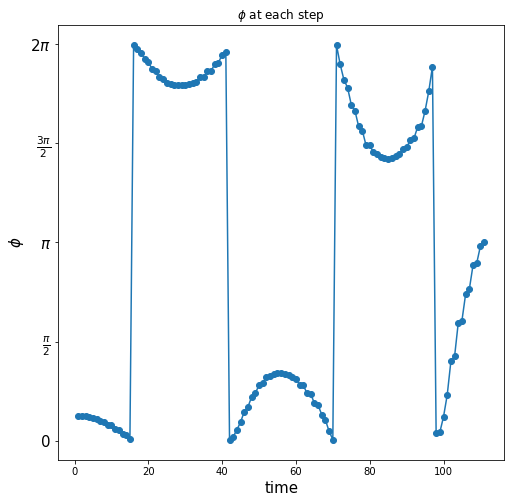

In [6]:
times = np.linspace(1, len(env.phi), len(env.phi))
plt.figure(figsize=(8, 8))
plt.plot(times, env.phi, "-o")
plt.title(r"$\phi$ at each step")
plt.xlabel("time", fontsize=15)
plt.ylabel(r"$\phi$", fontsize=15)
plt.yticks(
    np.linspace(0, 2 * np.pi, 5),
    labels=["0", r"$\frac{\pi}{2}$", r"$\pi$", r"$\frac{3\pi}{2}$", r"2$\pi$"],
    fontsize=15,
)
plt.show()

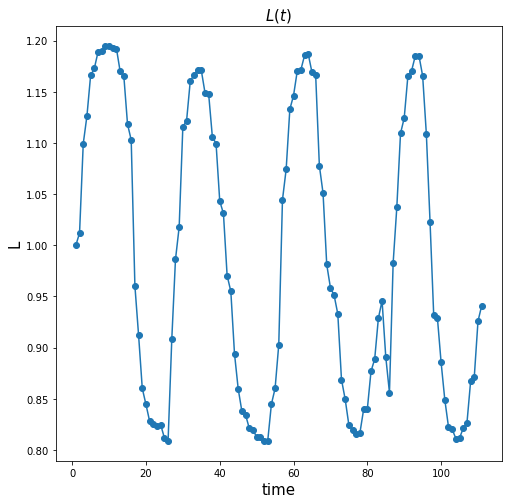

In [7]:
plt.figure(figsize=(8, 8))
plt.plot(times, env.L, "-o")
plt.xlabel("time", fontsize=15)
plt.ylabel(r"L", fontsize=15)
plt.title(r"$L(t)$", fontsize=15)
plt.show()

In [8]:
phi_dot = np.array(env.phi_dot)

In [9]:
phi_dot

array([-0.01      , -0.02814654, -0.18719333, -0.25896021, -0.42852028,
       -0.47517582, -0.6523784 , -0.67374464, -0.82837023, -0.84676281,
       -0.97104997, -0.98753639, -1.09817463, -1.12158956, -1.2443041 ,
       -1.28155119, -1.66472928, -1.81066643, -1.92488589, -1.91324027,
       -1.76569549, -1.66630139, -1.33115658, -1.22018224, -0.86646582,
       -0.72391815, -0.36379054, -0.04588401,  0.03078957,  0.34176523,
        0.36549462,  0.64148486,  0.72149695,  1.06178278,  1.07283922,
        1.40734899,  1.43330464,  1.7630178 ,  1.81879038,  2.16007889,
        2.23511559,  2.5620838 ,  2.6366237 ,  2.95412614,  3.0865647 ,
        3.01085436,  2.89188916,  2.58555385,  2.41491421,  1.92481307,
        1.73865744,  1.12582533,  0.94853291,  0.42047632,  0.06596738,
       -0.04086307, -0.43100744, -0.54107352, -0.90897917, -1.04132341,
       -1.4886468 , -1.52968085, -1.9361438 , -1.96832024, -2.37056631,
       -2.44927289, -3.10426891, -3.35846537, -3.97273432, -4.19

In [10]:
ch = np.where(phi_dot[:-1] * phi_dot[1:] < 0)[0]  # this array detects sign changes

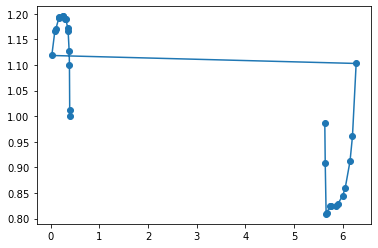

In [11]:
plt.plot(env.phi[: ch[0] + 1], env.L[: ch[0] + 1], "-o")

In [12]:
a = list(zip(env.phi, env.L, env.phi_dot))
a.sort(key=lambda x: x[0])

In [13]:
fq_phi = [p for p in a if p[0] < np.pi / 2]

In [14]:
fq_phi_up = [p for p in fq_phi if p[2] > 0]
fq_phi_down = [p for p in fq_phi if p[2] < 0]

In [15]:
def plot_L_vs_phi(env, first_quadrant=True):
    """
    This function takes in an environment and gives a plot of L vs phi.

    The complicated point is to account for the direction of motion and the
    side of the swing we are on.
    """
    a = list(zip(env.phi, env.phi_dot, env.L))
    a.sort(key=lambda x: x[0])
    plt.figure(figsize=(8, 8))
    if first_quadrant == True:
        tup = [p for p in a if p[0] < np.pi / 2]
        tup_up = [p for p in tup if p[1] > 0]
        tup_down = [p for p in tup if p[1] < 0]
        plt.xticks(
            [0, np.pi / 4, np.pi / 2],
            ["0", r"$\frac{\pi}{4}$", r"$\frac{\pi}{2}$"],
            fontsize=15,
        )
        # plt.xlim([0, np.pi/2])
    else:
        tup = [p for p in a if p[0] > 3 * np.pi / 2]
        tup_up = [p for p in tup if p[1] > 0]
        tup_down = [p for p in tup if p[1] < 0]
        plt.xticks(
            [3 * np.pi / 2, 2 * np.pi], [r"$\frac{3\pi}{2}$", r"$2\pi$"], fontsize=15
        )

    phi_up = np.array([p[0] for p in tup_up])
    l_up = np.array([p[2] for p in tup_up])

    phi_down = np.array([p[0] for p in tup_down])
    l_down = np.array([p[2] for p in tup_down])

    plt.plot(phi_up, l_up, "--o", label="ascent")
    plt.plot(phi_down, l_down, "--o", label="descent")
    # plt.arrow(phi_up[5], l_up[5], phi_up[5]+0.01, l_up[5]+0.01)
    plt.legend()
    plt.xlabel(r"$\phi$", fontsize=15)
    plt.ylabel("L", fontsize=15)
    plt.title(r"L vs $\phi$", fontsize=15)
    plt.show()

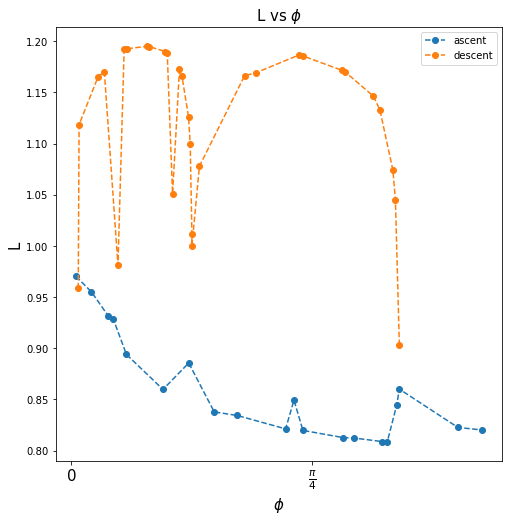

In [16]:
plot_L_vs_phi(env)

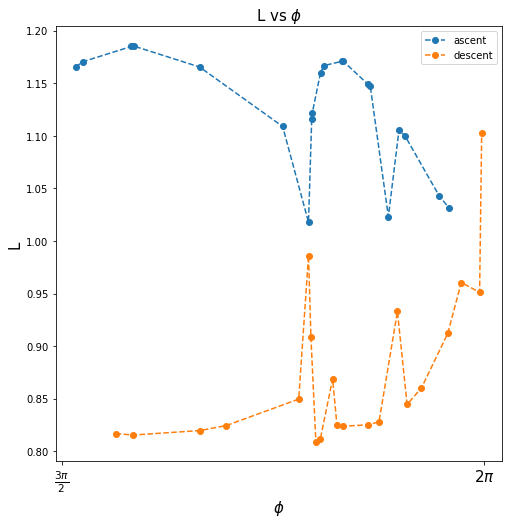

In [17]:
plot_L_vs_phi(env, False)

In [18]:
phi_up_sorted = np.array([p[0] for p in fq_phi_up])
phi_down_sorted = np.array([p[0] for p in fq_phi_down])
l_up_sorted = np.array([p[1] for p in fq_phi_up])
l_down_sorted = np.array([p[1] for p in fq_phi_down])

In [19]:
# idxs = np.where(phi_sorted < np.pi/2)[0]

In [20]:
# small_phi = phi_sorted[list(idxs)]
# small_phi_l = l_sorted[list(idxs)]

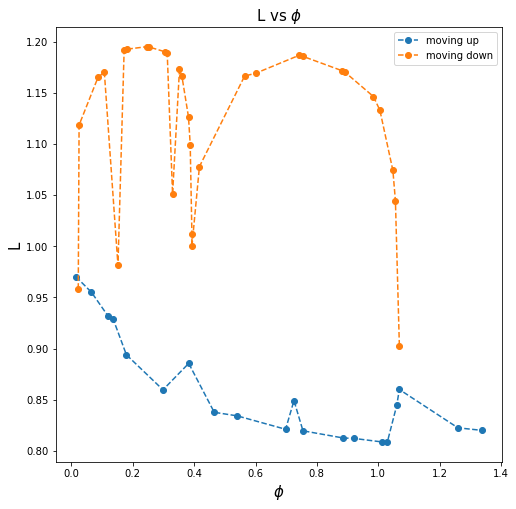

In [21]:
plt.figure(figsize=(8, 8))
# plt.plot(neg_omeg_thetas, neg_omeg_Ls, '-o')
plt.plot(phi_up_sorted, l_up_sorted, "--o", label="moving up")
plt.plot(phi_down_sorted, l_down_sorted, "--o", label="moving down")
plt.legend()
# plt.plot(small_phi[::3], small_phi_l[::3], '-o')
plt.xlabel(r"$\phi$", fontsize=15)
plt.ylabel("L", fontsize=15)
# plt.xticks(
#     [0, np.pi / 4, np.pi, 7 * np.pi / 4, 2 * np.pi],
#     [r"0", r"$\frac{\pi}{4}$", r"$\pi$", r"$\frac{7\pi}{4}$", r"2$\pi$"],
# )
plt.title(r"L vs $\phi$", fontsize=15)
plt.show()

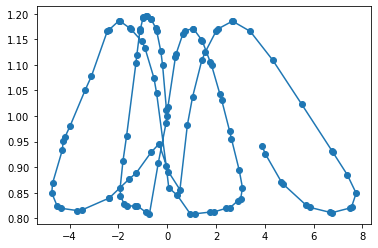

In [22]:
plt.plot(env.phi_dot, env.L, "-o")

In [23]:
# plt.figure(figsize=(8, 8))
# plt.plot(times, a_actions, "-o")
# plt.xlabel("time", fontsize=15)
# plt.ylabel("a", fontsize=15)
# plt.title(r"$a(t)$", fontsize=15)
# plt.show()

In [ ]:
# f, ax = plt.subplots(figsize=(10, 10))

# ax.plot(times, d_actions, "-o")
# # ax.yaxis.set_major_formatter(tck.FormatStrFormatter('$\pi$'))
# # ax.yaxis.set_major_locator(tck.MultipleLocator(base=0.5))
# # plt.plot(times, d_actions[-23:], "-o")
# ax.set_xlabel("time", fontsize=15)
# ax.set_ylabel(r"$\delta$", fontsize=15)
# ax.set_title(r"$\delta(t)$", fontsize=15)
# ax.set_yticks(
#     np.linspace(-np.pi, np.pi, 3), labels=[r"-$\pi$", r"0", r"$\pi$"], fontsize=15
# )
# plt.show()

$$(\phi, \dot{\phi})$$

In [ ]:
x_pos = np.array(env.L) * np.sin(env.phi)
y_pos = -np.array(env.L) * np.cos(env.phi)
ref_x = np.array(env.l_max) * np.sin(env.phi)
ref_y = -np.array(env.l_max) * np.cos(env.phi)
pos_arr = np.vstack((x_pos, y_pos))
ref_pos_arr = np.vstack((ref_x, ref_y))
np.save("positions_arr", pos_arr)
np.save("ref_pos_arr", ref_pos_arr)